# Zomato Restaurant Reviews Project

The scope of this project is to explore restaurant data collected from Zomato.
We want to explore it for any interesting trends, and answer a few over-arching questions
1. What effect does price have on ratings? With other variables accounted for, do people feel more compelled to rate a restaurant highly if they've paid more for the experience?
2. Do different countries have different standards for rating?
3. Do different kinds of cuisines have advantages when it comes to ratings? What cuisine is at a disadvantage?
4. How well could we predict ratings given the variables in the dataset?

to do:
- write function docstrings for all functions
- Partition project into clear stages (gather, access, clean, analyze, model, visualize)

CRISP-DM breaks the process of data mining into six major phases[15]:

Business Understanding
Data Understanding
Data Preparation
Modeling
Evaluation
Deployment

3-5 Questions asked and answered with visualization

In [207]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.feature_selection import RFE
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
df = pd.read_csv("zomato.csv", encoding = 'latin-1')

In [83]:
df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


Lets fix the column names up a bit

In [84]:
df.rename(columns = {'Restaurant ID': 'restaurant_id',
                     'Restaurant Name':'restaurant_name',
                     'Country Code':'country_code',
                     'City':'city',
                     'Address':'address',
                     'Locality':'locality',
                     'Locality Verbose':'locality_verbose',
                     'Longitude':'longitude',
                     'Latitude':'latitude',
                     'Cuisines':'cuisines',
                    'Has Table booking':'has_table_booking',
                    'Has Online delivery':'has_online_delivery',
                    'Is delivering now':'is_delivering_now',
                    'Switch to order menu':'switch_to_order',
                    'Price range':'price_range',
                    'Aggregate rating':'agg_rating',
                    'Rating color':'rating_color',
                    'Rating text':'rating_text',
                    'Votes':'votes',
                    'Average Cost for two':'avg_cost',
                    'Currency':'currency'}, inplace = True)

In [85]:
df.describe()

,restaurant_id,country_code,longitude,latitude,avg_cost,price_range,agg_rating,votes
count,9.551000e+03,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000
mean,9.051128e+06,18.365616,64.126574,25.854381,1199.210763,1.804837,2.666370,156.909748
std,8.791521e+06,56.750546,41.467058,11.007935,16121.183073,0.905609,1.516378,430.169145
min,5.300000e+01,1.000000,-157.948486,-41.330428,0.000000,1.000000,0.000000,0.000000
25%,3.019625e+05,1.000000,77.081343,28.478713,250.000000,1.000000,2.500000,5.000000
50%,6.004089e+06,1.000000,77.191964,28.570469,400.000000,2.000000,3.200000,31.000000
75%,1.835229e+07,1.000000,77.282006,28.642758,700.000000,2.000000,3.700000,131.000000
max,1.850065e+07,216.000000,174.832089,55.976980,800000.000000,4.000000,4.900000,10934.000000


A few things here worry me, one is avg_costs of 0, and the other is 0 ratings, lets see how many of each there are.

In [86]:
len(df[df['agg_rating'] == 0])

2148

Ok, not too bad, but since it's our dependent variable we will need to get rid of these instances.

In [87]:
df = df[df.agg_rating > 0]

In [91]:
df.shape

(7403, 21)

So, we're down to 7,403 usable data points, lets see what we can do about restaurants with 0's for cost.

In [96]:
(df.avg_cost == 0).sum()

18

Ok, not so bad at all, only 18 without an average cost for two people. We could consider imputing this value, possibly based on the country, but with so few missing, we will just drop them and move on.

In [102]:
df = df[df.avg_cost != 0]

Ok, lets do a quick histogram of any numerical data and see what we can observe.

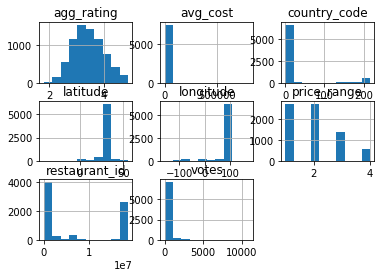

In [98]:
df.hist();

Average ratings have a near perfect normal distribution. Average cost for two also seems highly skewed and clearly need to be adjust for fx_rates. Price range makes sense, as most restaurants are on the lower end, and fewer as price increases. Votes are highly skewed and will need looking into.
Lets handle the FX rates first and see how it looks.

In [104]:
''' Function takes a dataframe with currency and non-uniform pricing,
and returns a dataframe with a column for USD value of the currency '''
def fx_adj_price(df):    
    #Get current list of currencies
    fx_rates = df.currency.value_counts().reset_index()
    #drop currency text from currency table
    fx_rates = fx_rates.drop(['currency'], axis = 1)
    fx_rates.rename(columns = {'index':'currency'}, inplace = True)
    fx_rates['usd_rate'] = [.014,1,1.2489,.2722,.2448,.0686,.6377,.1758,.0921,.000072,.005545,.2747]
    fx_rates['country'] =  ['india','usa','uk','uae','brazil','south_africa','new_zealand','turkey',
                            'botswana','indonesia','sri_lanka','qatar']
    
    #Assign each row fx rate
    df = df.merge(fx_rates, how = 'left', on = 'currency')
    #Get usd value of prices for each restaurant
    df['usd_avg_price'] = df['avg_cost'] * df['usd_rate']
    df = df.drop(['avg_cost','usd_rate'], axis =1)
    return df

count    7385.000000
mean       13.814733
std        23.227416
min         0.700000
25%         5.600000
50%         8.400000
75%        14.000000
max       785.808000
Name: usd_avg_price, dtype: float64


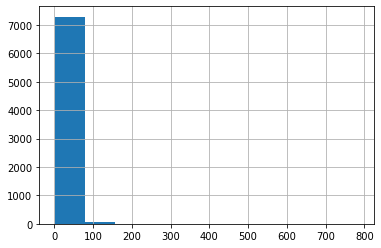

In [105]:
df_usd = fx_adj_price(df)
print(df_usd['usd_avg_price'].describe())
df_usd['usd_avg_price'].hist()

Still looks skewed, lets dig into how it looks in the 1-50 range.

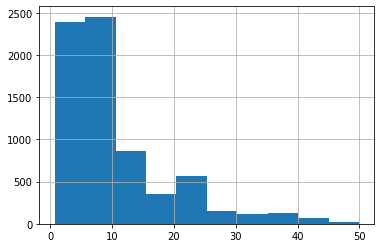

In [106]:
df_usd['usd_avg_price'][df_usd['usd_avg_price'] < 50].hist();

Still skewed, looks like most of these restaurants can be had for less than $10 for two!
Curious how this looks by country, lets this split histogram apart.

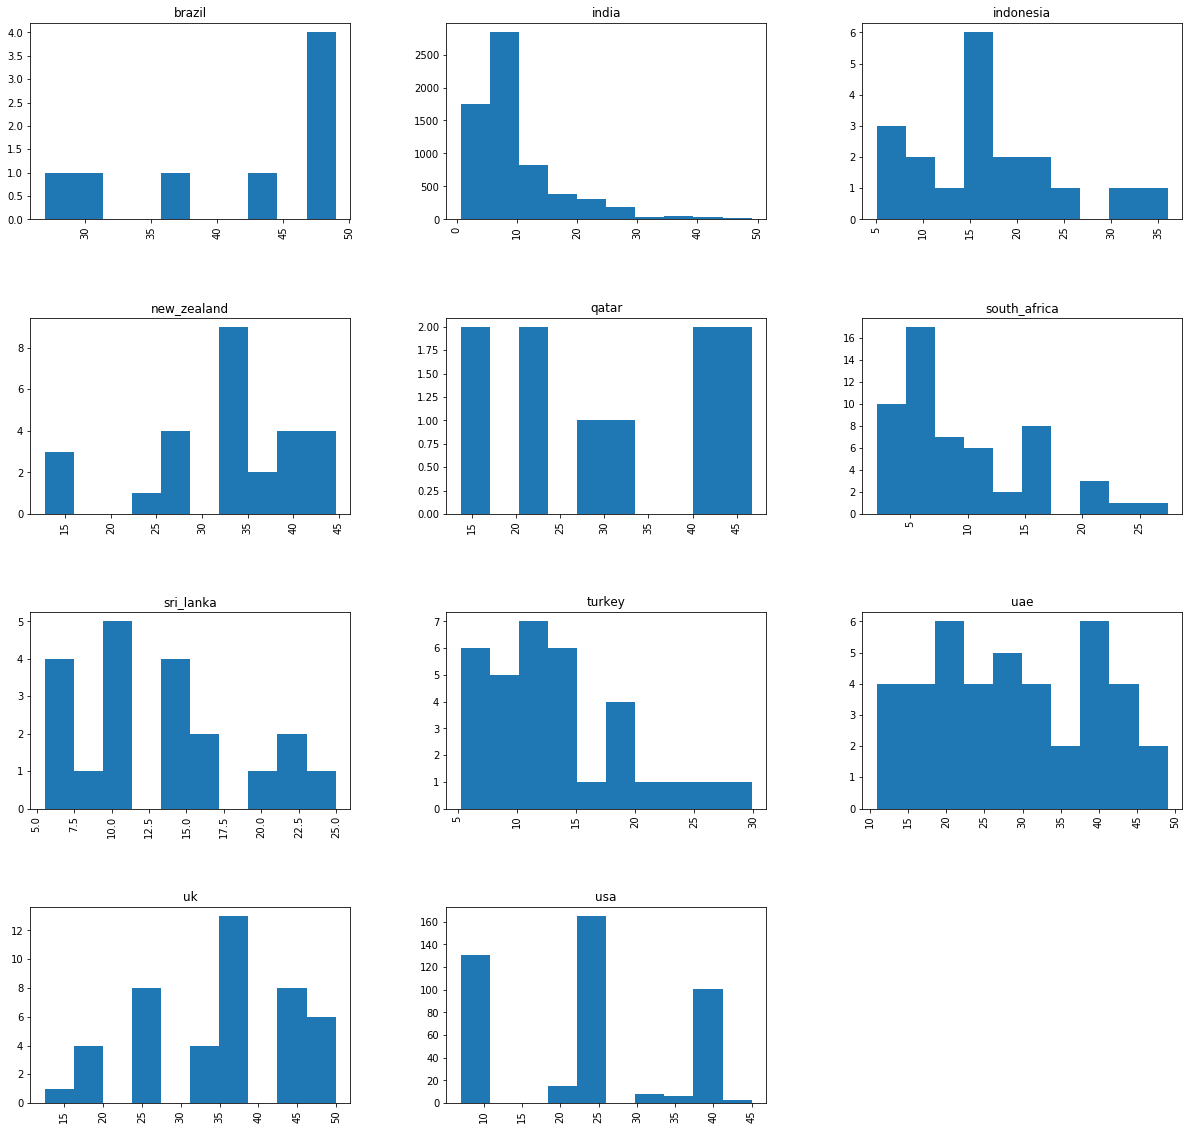

In [107]:
df_usd[['usd_avg_price','country']][df_usd['usd_avg_price'] < 50].hist(column = 'usd_avg_price', by= 'country', figsize = (20,20));

Looks like the distribution is significantly different accross countries. Also seems that the price for two is more of a bucket range than an exact amount for certain countries, given gaps in what is otherwise normally distributed.

Lets see how average ratings look accross countries.

<BarContainer object of 12 artists>

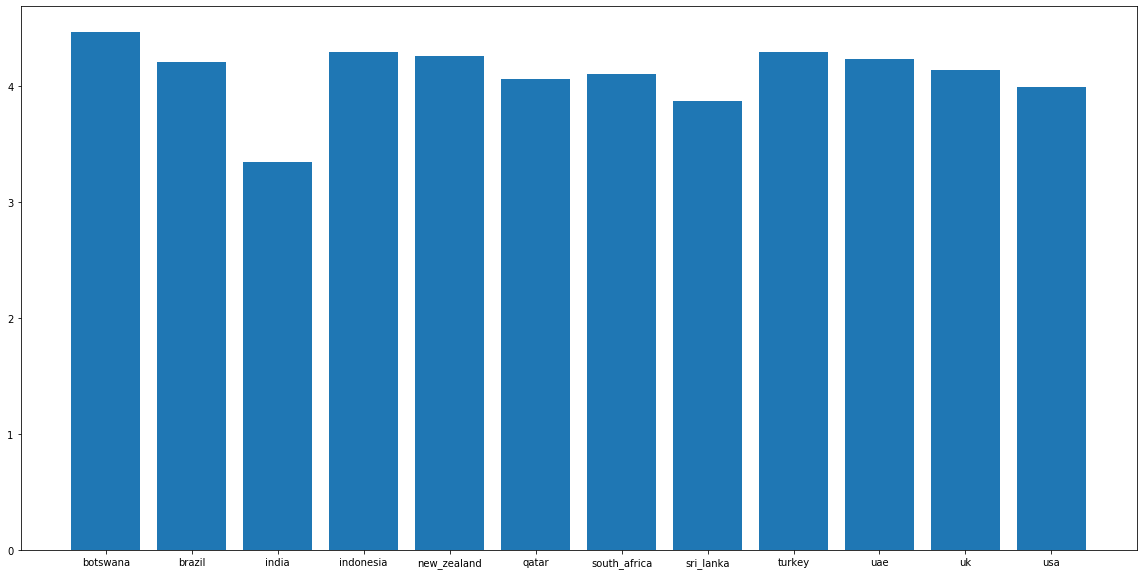

In [257]:
countries = df_usd.groupby('country')['agg_rating'].mean()
plt.subplots(figsize = (20,10))
plt.bar(countries.index, countries)

Most countries hoover close to or slightly above a 4 rating, but India has a much lower average, which seems to suggest either the restaurants are not as good in India, that they are rated more harshly, or that the subset of restaurants chosen in India are different than the sampling in other countries.

Lets go ahead and split the data into numerical and categorical parts to continue digging deeper.

In [108]:
''' Take in a dataframe and parse into its numerical and categorical parts

    INPUT:
        df - Dataframe to parse
    OUTPUT:
        df_base - df of all descriptive variabls (name, id, etc)
        df_cat - df of all categorical variables
        df_num - df of all numerical variables
        '''
def split_data(df):
    df_num = df.select_dtypes(include = ['float64','int64'])
    
    #Get rid of some of the numeric columns that don't make sense to use
    df_num = df_num.drop(['restaurant_id','country_code'], axis = 1)
    
    df_cat = df.select_dtypes(include = ['object'])
    df_cat = df_cat.drop(['rating_color','rating_text','locality','locality_verbose','address','currency',
                         'restaurant_name','city','switch_to_order'], axis = 1)
    
    df_base = df[['restaurant_id','restaurant_name']]
    
    return df_base, df_num, df_cat
    

In [109]:
df_base, df_num, df_cat = split_data(df_usd)
df_cat.head()

,cuisines,has_table_booking,has_online_delivery,is_delivering_now,country
0,"French, Japanese, Desserts",Yes,No,No,botswana
1,Japanese,Yes,No,No,botswana
2,"Seafood, Asian, Filipino, Indian",Yes,No,No,botswana
3,"Japanese, Sushi",No,No,No,botswana
4,"Japanese, Korean",Yes,No,No,botswana


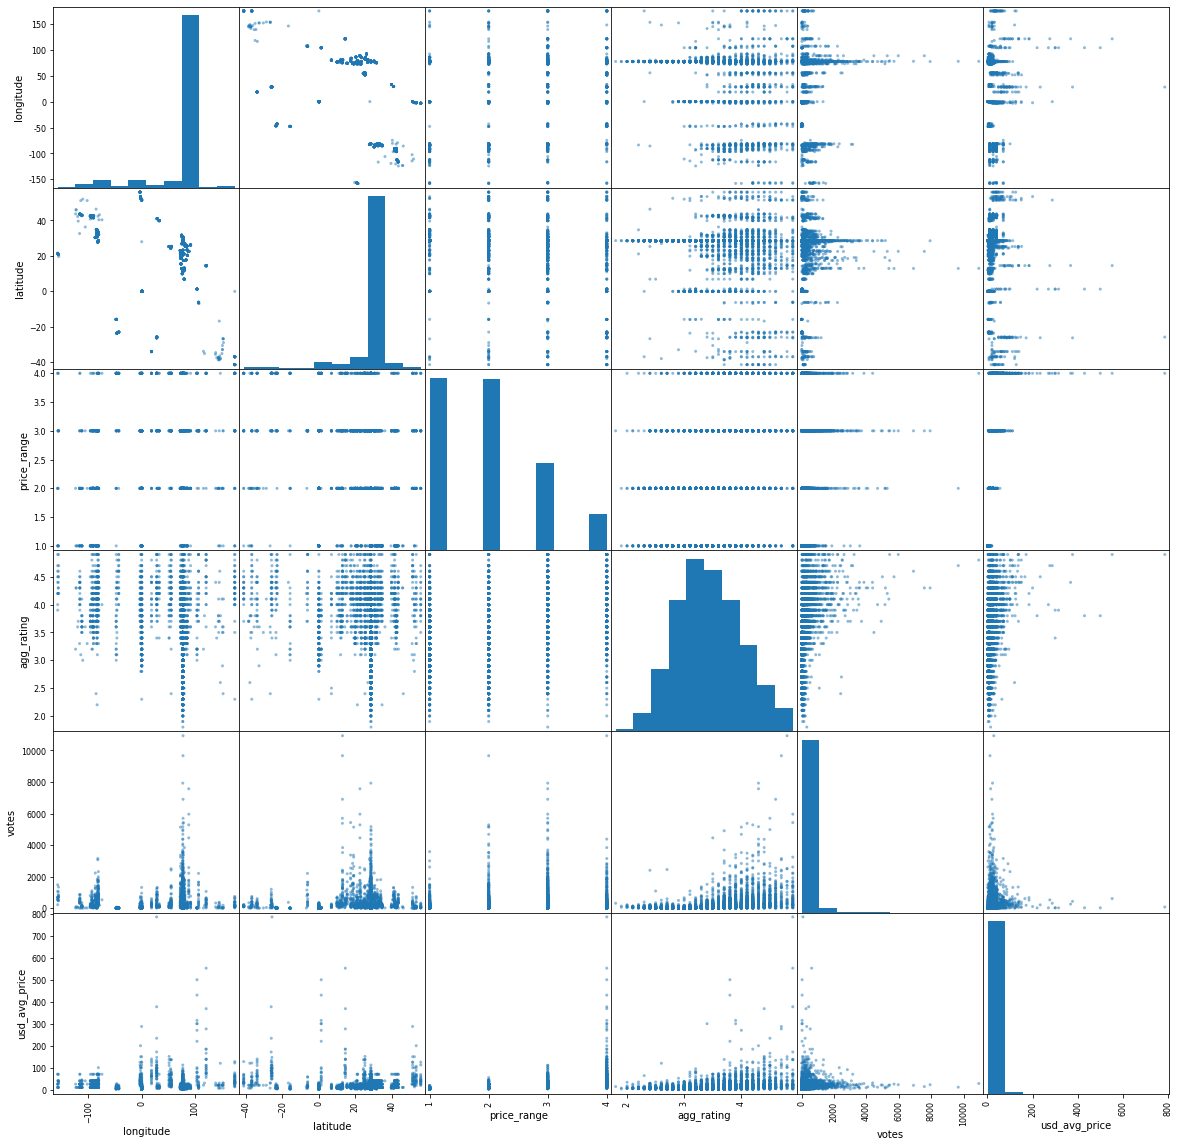

In [110]:
scatter_matrix(df_num, figsize = (20,20));

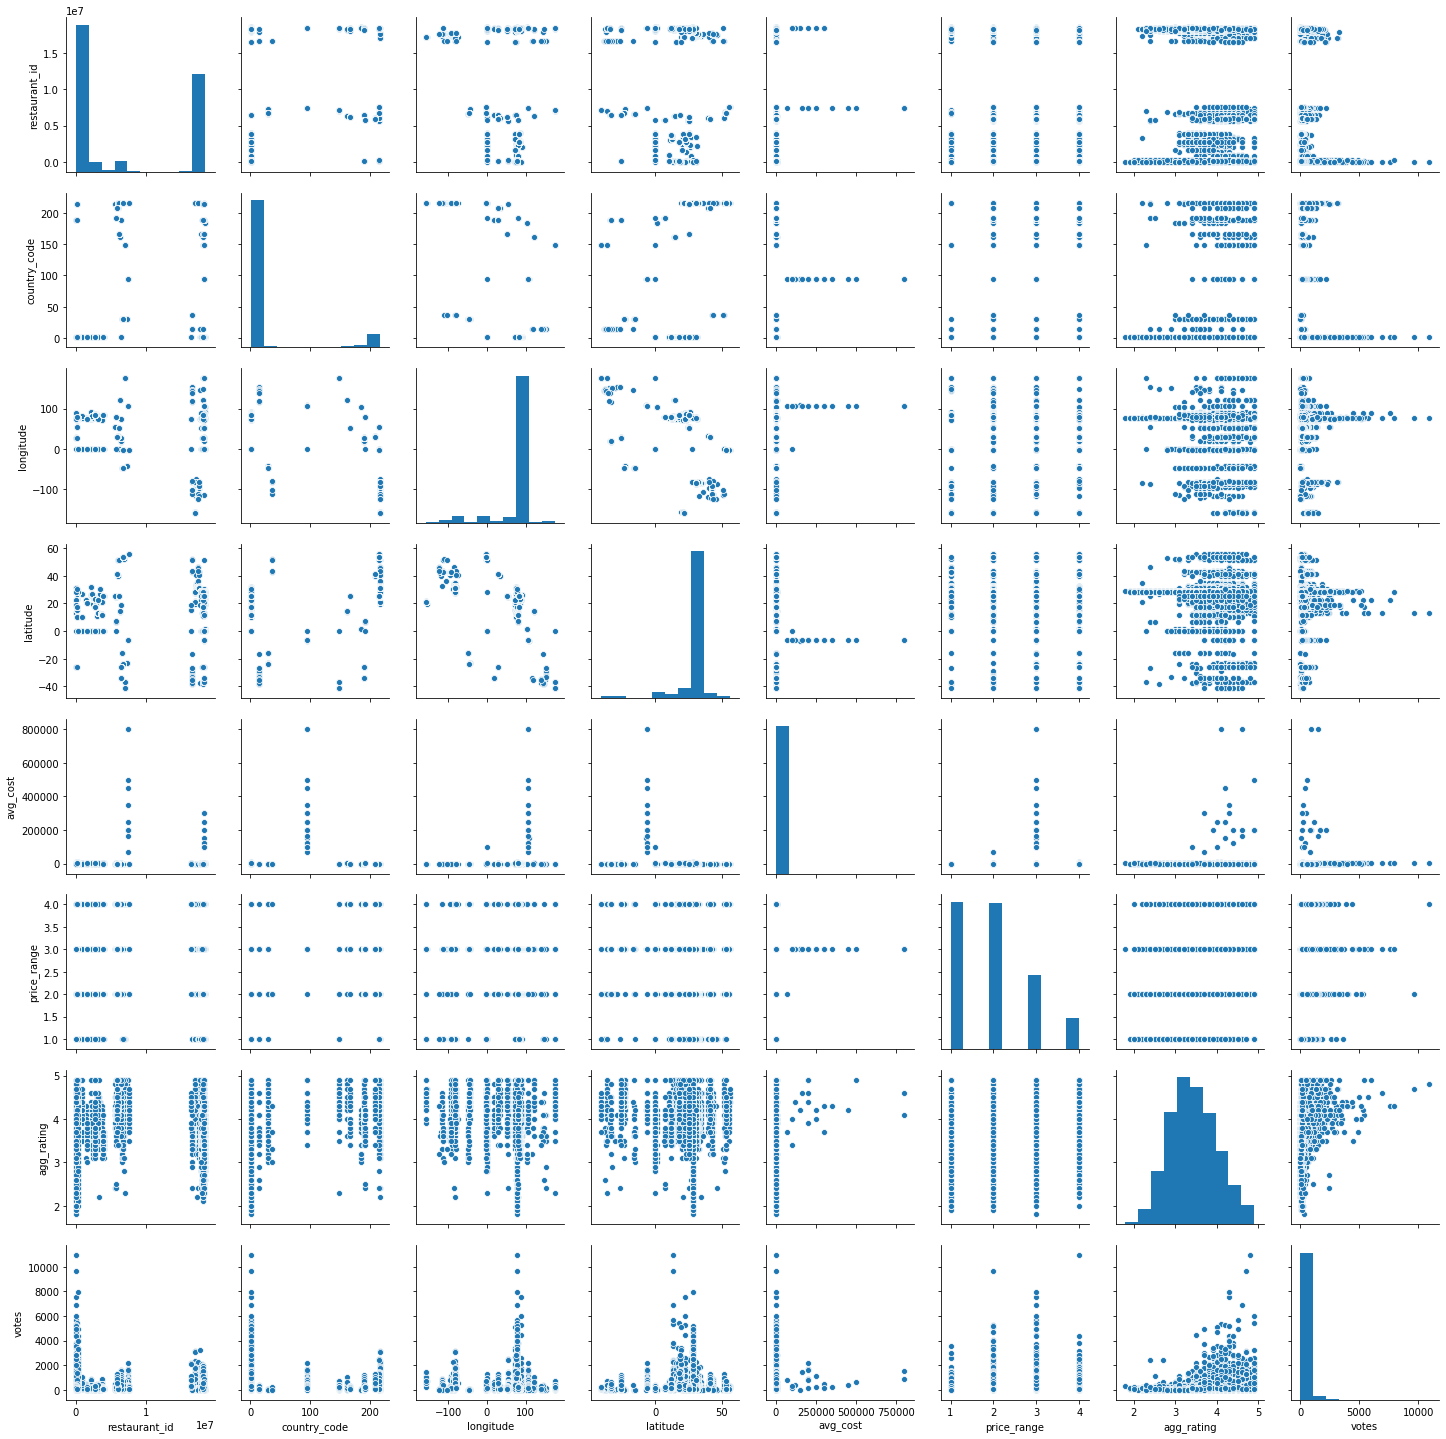

In [111]:
sns.pairplot(df);

Looks similar, but seaborn's is a bit cleaner looking.

Lets look at these categorical variables and what we will do with each

In [112]:
print(df_cat.country.value_counts())

india           6504
usa              470
uk                79
brazil            60
uae               60
south_africa      55
new_zealand       40
turkey            34
botswana          22
indonesia         21
sri_lanka         20
qatar             20
Name: country, dtype: int64


The vast majority are in India, lets see if the model works if we turn each country into a dummy variable. We can consider further regionalizing the data to make larger groups later.

In [113]:
df_cat.cuisines.value_counts()

North Indian                                                           492
North Indian, Chinese                                                  397
North Indian, Mughlai                                                  294
Cafe                                                                   252
Fast Food                                                              228
Chinese                                                                224
North Indian, Mughlai, Chinese                                         164
Bakery                                                                 130
Bakery, Desserts                                                       116
Pizza, Fast Food                                                       113
Street Food                                                             94
South Indian                                                            81
Chinese, Fast Food                                                      80
Bakery, Fast Food        

Wow, thats a lot of cuisine types, lets see if we can wrangle this into a more reasonable dummy sequence. Because there are restaurants with multiple cuisine types, we will need to parse them out to get the dummy values we want.

In [114]:
'''Function takes in a catgorical variable Series, and 
returns a dataframe of all individual values within that column'''
def individual_values(df_cat_col):
    cols = df_cat_col.str.split(pat = ', ')
    unique_vals = cols.apply(pd.Series).stack().unique()
    return unique_vals, cols

In [115]:
vals, cols = individual_values(df_cat.cuisines)
print('There are {} individual cuisine types.'.format(len(vals)))

There are 143 individual cuisine types.


143 is not too bad, we can try to make dummy variables for each and see how they're distributed.

In [116]:
def get_cuisine_dummies(cuisine):
    cuisine.str.get_dummies(sep = ', ')

In [117]:
test = df_cat.cuisines.str.get_dummies(sep = ', ')
print(test)

      Afghani  African  American  Andhra  Arabian  Argentine  Armenian  Asian  \
0           0        0         0       0        0          0         0      0   
1           0        0         0       0        0          0         0      0   
2           0        0         0       0        0          0         0      1   
3           0        0         0       0        0          0         0      0   
4           0        0         0       0        0          0         0      0   
5           0        0         0       0        0          0         0      0   
6           0        0         0       0        0          0         0      1   
7           0        0         0       0        0          0         0      1   
8           0        0         0       0        0          0         0      1   
9           0        0         0       0        0          0         0      0   
10          0        0         0       0        0          0         0      0   
11          0        0      

In [119]:
def get_cat_dum(df_cat):
        dummy_1 = pd.get_dummies(df_cat['has_table_booking'])
        dummy_2 = pd.get_dummies(df_cat['has_online_delivery'])
        dummy_3 = pd.get_dummies(df_cat['is_delivering_now'])
        dummy_4 = pd.get_dummies(df_cat['country'])
        dummies = pd.DataFrame()
        dummies['table_booking'] = dummy_1['Yes']
        dummies['online_delivery'] = dummy_2['Yes']
        dummies['delivering_now'] = dummy_3['Yes']
        
        #For the Cuisines
        cuisine_dummies = df_cat.cuisines.str.get_dummies(sep = ', ')
        
        dummies = pd.concat([dummies, dummy_4, cuisine_dummies], axis = 1)
        
        return dummies

In [120]:
dummies = get_cat_dum(df_cat)

In [121]:
dummies.head()

,table_booking,online_delivery,delivering_now,botswana,brazil,india,indonesia,new_zealand,qatar,south_africa,...,Teriyaki,Tex-Mex,Thai,Tibetan,Turkish,Turkish Pizza,Vegetarian,Vietnamese,Western,World Cuisine
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Looks about right, lets check the overall shape

In [122]:
dummies.shape

(7385, 158)

Looks right, we have our 9551 rows, 143 columns for cuisines, three binary variables, and 12 different countries, exactly the 158 columns in the dataframe. Now time to deal with numerical variables.

In [231]:
df_num.describe()

,longitude,latitude,price_range,agg_rating,votes,usd_avg_price
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,63.655801,26.175053,1.972512,3.439242,202.482600,13.814733
std,44.396570,11.263635,0.930509,0.552279,479.736125,23.227416
min,-157.948486,-41.330428,1.000000,1.800000,4.000000,0.700000
25%,77.083023,28.475672,1.000000,3.000000,19.000000,5.600000
50%,77.191874,28.569997,2.000000,3.400000,60.000000,8.400000
75%,77.272053,28.645085,3.000000,3.800000,182.000000,14.000000
max,174.832089,55.976980,4.000000,4.900000,10934.000000,785.808000


I don't think there's too much needs to be done here, but we can transform it all using a standard scaler to speed up our machine learning. Before we do that though, lets explore some of the variables independently.

In [128]:
scaler = StandardScaler()
df_num_std = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns)

In [129]:
df_num_std.describe()

,longitude,latitude,price_range,agg_rating,votes,usd_avg_price
count,7.385000e+03,7.385000e+03,7.385000e+03,7.385000e+03,7.385000e+03,7.385000e+03
mean,1.162419e-15,7.056719e-17,-3.562186e-15,-1.783032e-15,-3.087578e-16,-8.467612e-17
std,1.000068e+00,1.000068e+00,1.000068e+00,1.000068e+00,1.000068e+00,1.000068e+00
min,-4.991811e+00,-5.993629e+00,-1.045210e+00,-2.968343e+00,-4.137609e-01,-5.646612e-01
25%,3.024587e-01,2.042658e-01,-1.045210e+00,-7.953799e-01,-3.824916e-01,-3.536893e-01
50%,3.049107e-01,2.126406e-01,2.954297e-02,-7.105897e-02,-2.970221e-01,-2.331340e-01
75%,3.067168e-01,2.193075e-01,1.104296e+00,6.532619e-01,-4.269845e-02,7.976770e-03
max,2.504333e+00,2.646033e+00,2.179049e+00,2.645144e+00,2.237114e+01,3.323855e+01


Now let's combine all the data, and separate ratings as our y variable.

In [189]:
def get_data(df_num_std, df_dum):
    data = pd.concat([df_num_std, df_dum], axis = 1)
    y = data['agg_rating']
    X = data.drop(['agg_rating'], axis = 1)
    
    return X, y, data

In [200]:
X, y, data = get_data(df_num_std, dummies)

Lets take a quick look at our correlations against ratings

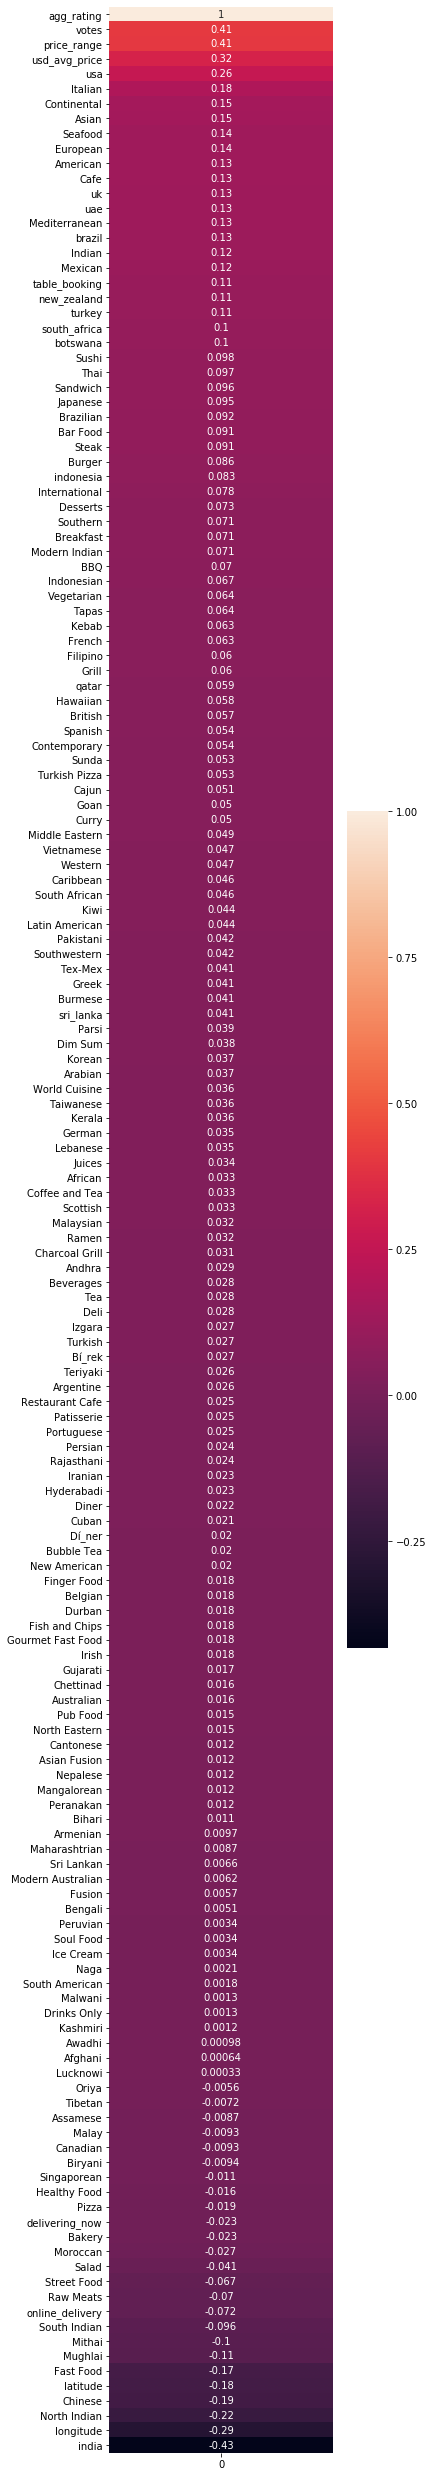

In [203]:
corr = pd.DataFrame(data.corrwith(data['agg_rating']))
plt.subplots(figsize = (5,45))
sns.heatmap(corr.sort_values(by = [0], ascending = False), annot = True)

Looks like there are not many strong correlations, but there are a few to note.
 - Number of votes being related to ratings makes sense, since a good restaurant is more popular, and thus gets more ratings
 - Price variables coming up next makes some sense, as higher priced restaurants often serve higher-quality food. The question here is do people consider price fully when rating a place? Is there an innate desire to rate more expensive places as better?
 - Restaurants in the USA correlate with high ratings, is it a cultural thing?
 - Italian food is the cuisine most closely related to ratings
 - India is negatively correlated with ratings, either they are harsher in ratings than other countries, or the restaurants are, on average, seen as less appealing than others
 - Longitude being negatively related here may stem from the skewed number of restaurants in India vs the rest of the world

Time to split the data into train and test sets

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [204]:
def rmse(y_test, y_pred):
     return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [205]:
def regress_summary(X, y):
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

In [206]:
lr_m = LinearRegression()
lr_m.fit(X_train, y_train)
lr_pred = lr_m.predict(X_test)
lr_m_rmse = rmse(y_test, lr_pred)
test = metrics.mean_squared_error(y_test, lr_pred)
print(test)
print(rmse(lr_pred, y_test))

regress_summary(X_train, y_train)

3.37861874454911e+20
18381019407.39172
                            OLS Regression Results                            
Dep. Variable:             agg_rating   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     29.09
Date:                Fri, 20 Sep 2019   Prob (F-statistic):               0.00
Time:                        14:10:32   Log-Likelihood:                -5649.9
No. Observations:                5169   AIC:                         1.162e+04
Df Residuals:                    5011   BIC:                         1.265e+04
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [188]:
svr = SVR()
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)
svr_rmse = rmse(y_test, pred)
svr_rmse

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


18381019407.39172

In [185]:
lasso = Lasso(alpha = 0.001)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
rmse(y_test, lasso_pred)

0.7554402238499643

In [271]:
selector = RFE(lasso, 30, step = 1)
selector = selector.fit(X_train, y_train)
columns = pd.Series(selector.support_, index = list(X_train.columns))
selected_features = columns[columns == True].index.to_list()
print(selected_features)

['price_range', 'votes', 'india', 'south_africa', 'turkey', 'uk', 'American', 'Asian', 'Beverages', 'Brazilian', 'Cafe', 'Chinese', 'Continental', 'Desserts', 'Finger Food', 'Indian', 'Italian', 'Kerala', 'Mediterranean', 'Mexican', 'Mithai', 'Modern Australian', 'Modern Indian', 'North Indian', 'Pizza', 'Salad', 'Sandwich', 'Steak', 'Street Food', 'Thai']


In [272]:
regress_summary(X_train[selected_features], y_train)

                            OLS Regression Results                            
Dep. Variable:             agg_rating   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     138.5
Date:                Fri, 20 Sep 2019   Prob (F-statistic):               0.00
Time:                        15:19:54   Log-Likelihood:                -5792.6
No. Observations:                5169   AIC:                         1.165e+04
Df Residuals:                    5138   BIC:                         1.185e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8571      0.04

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [223]:
type(selected_features)

pandas.core.indexes.base.Index